### Ulike analysemetoder er brukt i koden nedenfor

Fornøyd med denne. Jobb videre her. Alt fungerer som det skal.


Hva ønsker du å undersøke?
1: Pearson-korrelasjon
2: Seaborn-linjediagram
3: Punktdiagram
4: Regresjonsanalyse
5: Glidende gjennomsnitt
6: Boksplott per år
7: Interaktivt linjediagram (Plotly)
8: Punktdiagram som viser månedlige maks- og minverdier i havnivå
0: Avslutt



C:\Users\madsj\AppData\Local\Temp\ipykernel_7800\2182106180.py:144: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



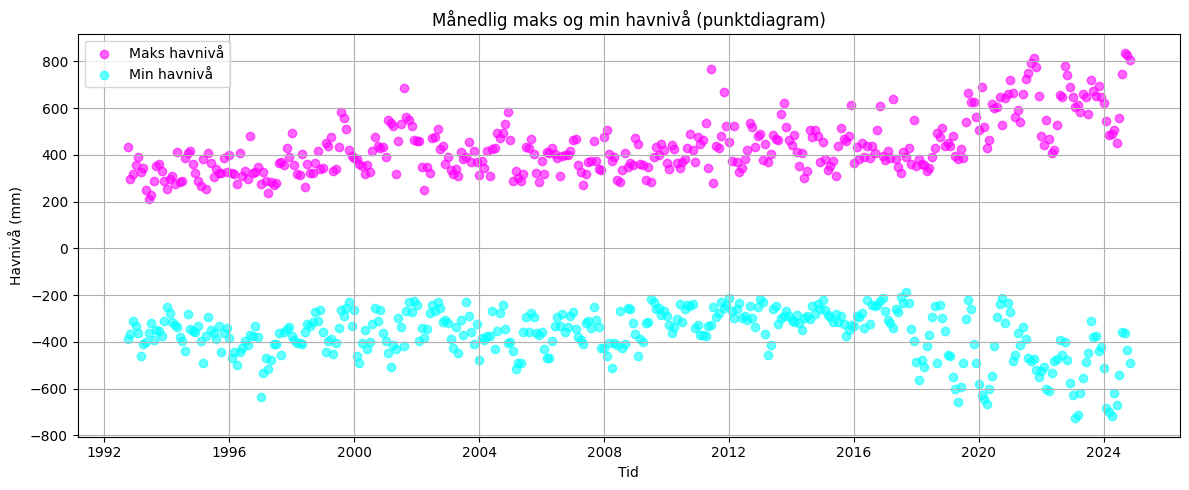


Hva ønsker du å undersøke?
1: Pearson-korrelasjon
2: Seaborn-linjediagram
3: Punktdiagram
4: Regresjonsanalyse
5: Glidende gjennomsnitt
6: Boksplott per år
7: Interaktivt linjediagram (Plotly)
8: Punktdiagram som viser månedlige maks- og minverdier i havnivå
0: Avslutt



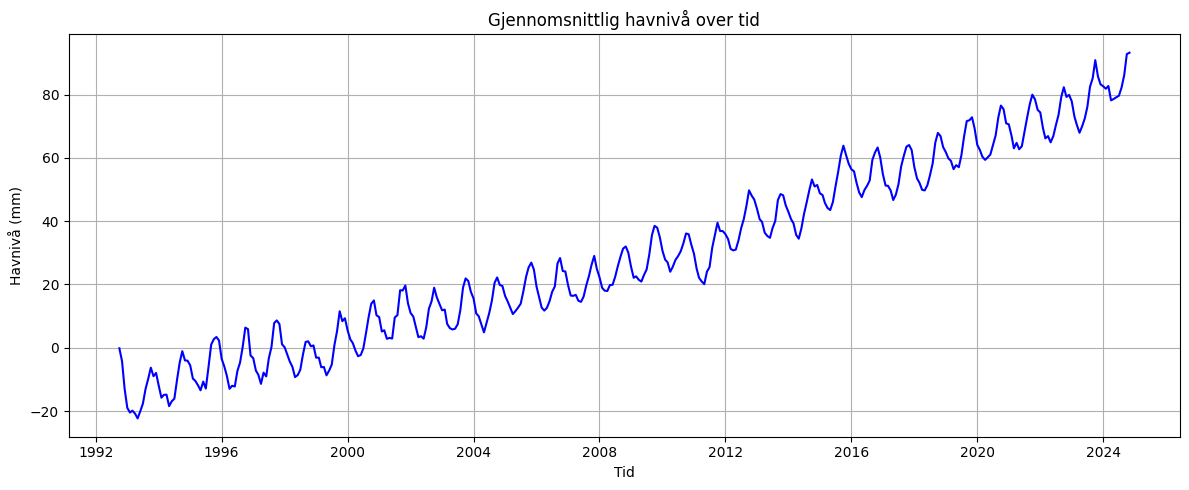


Hva ønsker du å undersøke?
1: Pearson-korrelasjon
2: Seaborn-linjediagram
3: Punktdiagram
4: Regresjonsanalyse
5: Glidende gjennomsnitt
6: Boksplott per år
7: Interaktivt linjediagram (Plotly)
8: Punktdiagram som viser månedlige maks- og minverdier i havnivå
0: Avslutt




Hva ønsker du å undersøke?
1: Pearson-korrelasjon
2: Seaborn-linjediagram
3: Punktdiagram
4: Regresjonsanalyse
5: Glidende gjennomsnitt
6: Boksplott per år
7: Interaktivt linjediagram (Plotly)
8: Punktdiagram som viser månedlige maks- og minverdier i havnivå
0: Avslutt

Avslutter programmet. Takk for at du analyserte havnivådataen!


In [7]:

import numpy as np
import pandas as pd
import requests
from datetime import datetime
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import nbformat
import IPython

# Viktig for å vise Plotly i VSCode
pio.renderers.default = "vscode"

# Hent data
response = requests.get(
    "https://sealevel-nexus.jpl.nasa.gov/timeSeriesSpark",
    params={
        "ds": "NASA_SSH_REF_SIMPLE_GRID_V1_Monthly",
        "b": "-180.0,-90.0,180.0,90.0",
        "startTime": "1992-01-01T00:00:00Z",
        "endTime": "2025-01-01T00:00:00Z",
        "output": "JSON"
    }
)

if response.ok and "data" in response.json():
    raw_data = [item for sublist in response.json()["data"] for item in sublist]
    df = pd.DataFrame(raw_data)
else:
    raise ValueError("Feil ved henting av data.")

# Forbered data
df = df.dropna(subset=["mean", "iso_time"])
df = df[df["mean"].between(-0.1, 0.1)]
df["iso_time"] = pd.to_datetime(df["iso_time"])
df["år"] = df["iso_time"].dt.year
df["mean_mm"] = df["mean"] * 1000

# Start meny-løkke
while True:
    print("\nHva ønsker du å undersøke?")
    print("1: Pearson-korrelasjon")
    print("2: Seaborn-linjediagram")
    print("3: Punktdiagram")
    print("4: Regresjonsanalyse")
    print("5: Glidende gjennomsnitt")
    print("6: Boksplott per år")
    print("7: Interaktivt linjediagram (Plotly)")
    print("8: Punktdiagram som viser månedlige maks- og minverdier i havnivå")
    print("0: Avslutt\n")

    valg = input("Skriv inn tallet for ønsket analyse: ")

    if valg == "1":
        korrelasjon, _ = pearsonr(df["år"], df["mean_mm"])
        print(f"\nKorrelasjon mellom år og havnivå: {korrelasjon:.3f}")
        print("Tolkning:")
        if korrelasjon > 0.7:
            print("Sterk positiv sammenheng (havnivået stiger over tid).")
        elif korrelasjon < -0.7:
            print("Sterk negativ sammenheng (havnivået synker over tid).")
        else:
            print("Svak eller ingen sammenheng.")

    elif valg == "2":
        plt.figure(figsize=(12, 5))
        sns.lineplot(data=df, x="iso_time", y="mean_mm", color="blue")
        plt.title("Gjennomsnittlig havnivå over tid")
        plt.xlabel("Tid")
        plt.ylabel("Havnivå (mm)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    elif valg == "3":
        # Gruppér data per år for å vise ett punkt per år
        df_årlig = df.groupby("år")["mean_mm"].mean().reset_index()
        plt.figure(figsize=(12, 5))
        plt.scatter(df_årlig["år"], df_årlig["mean_mm"], color="green", alpha=0.7)
        plt.xlabel("År")
        plt.ylabel("Gjennomsnittlig havnivå (mm)")
        plt.title("Gjennomsnittlig havnivå per år (punktdiagram)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    elif valg == "4":
        # Bruk den årlige gjennomsnittlige verdien
        df_årlig = df.groupby("år")["mean_mm"].mean().reset_index()
        koeff = np.polyfit(df_årlig["år"], df_årlig["mean_mm"], 1)
        regresjonslinje = np.polyval(koeff, df_årlig["år"])

        plt.figure(figsize=(12, 5))
        plt.scatter(df_årlig["år"], df_årlig["mean_mm"], alpha=0.6, color="gray", label="Årlig gjennomsnitt")
        plt.plot(df_årlig["år"], regresjonslinje, color="red", label="Regresjonslinje")
        plt.xlabel("År")
        plt.ylabel("Gjennomsnittlig havnivå (mm)")
        plt.title("Gjennomsnittlig havnivå per år med regresjonslinje")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    elif valg == "5":
        df["glidende_mean"] = df["mean_mm"].rolling(window=12).mean()

        plt.figure(figsize=(12, 5))
        plt.plot(df["iso_time"], df["mean_mm"], label="Rådata", alpha=0.3)
        plt.plot(df["iso_time"], df["glidende_mean"], label="Glidende gjennomsnitt (12 mnd)", color="red")
        plt.xlabel("Tid")
        plt.ylabel("Havnivå (mm)")
        plt.title("Gjennomsnittlig havnivå over tid med glidende gjennomsnitt")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    elif valg == "6":
        plt.figure(figsize=(15, 6))
        df.boxplot(column="mean_mm", by="år", grid=True, showfliers=False)
        plt.title("Gjennomsnittlig havnivå per år (uten ekstremverdier)")
        plt.suptitle("")
        plt.xlabel("År")
        plt.xticks(rotation=45)
        plt.ylabel("Havnivå (mm)")
        plt.tight_layout()
        plt.show()

    elif valg == "7":
        df_årlig = df.groupby("år")["mean_mm"].mean().reset_index()
        fig = px.line(
            df_årlig,
            x="år",
            y="mean_mm",
            title="Gjennomsnittlig havnivå over tid (interaktiv graf)",
            labels={"mean_mm": "Havnivå (mm)", "år": "År"}
        )
        fig.update_layout(hovermode="x unified")
        fig.show()

    elif valg == "8":
        df["måned"] = df["iso_time"].dt.to_period("M")
        
        # Bruk de faktiske 'min' og 'max' kolonnene for hver måned
        df_maks = df.groupby("måned")["max"].max().reset_index()
        df_min = df.groupby("måned")["min"].min().reset_index()
        
        # Gjør om til tidsstempel
        df_maks["måned"] = df_maks["måned"].dt.to_timestamp()
        df_min["måned"] = df_min["måned"].dt.to_timestamp()
        
        # Plot som punktdiagram med ulike farger
        plt.figure(figsize=(12, 5))
        plt.scatter(df_maks["måned"], df_maks["max"] * 1000, color="magenta", alpha=0.6, label="Maks havnivå")
        plt.scatter(df_min["måned"], df_min["min"] * 1000, color="cyan", alpha=0.6, label="Min havnivå")
        
        plt.title("Månedlig maks og min havnivå (punktdiagram)")
        plt.xlabel("Tid")
        plt.ylabel("Havnivå (mm)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()





    elif valg == "0":
        print("Avslutter programmet. Takk for at du analyserte havnivådataen!")
        break

    else:
        print("Ugyldig valg. Prøv igjen med et tall fra 0 til 8.")


Ny kode ved bruk av funksjoner

In [ ]:
import numpy as np 
import pandas as pd
import requests
from datetime import datetime
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown

pio.renderers.default = "vscode"

# Hent data
response = requests.get(
    "https://sealevel-nexus.jpl.nasa.gov/timeSeriesSpark",
    params={
        "ds": "NASA_SSH_REF_SIMPLE_GRID_V1_Monthly",
        "b": "-180.0,-90.0,180.0,90.0",
        "startTime": "1992-01-01T00:00:00Z",
        "endTime": "2025-01-01T00:00:00Z",
        "output": "JSON"
    }
)

if response.ok and "data" in response.json():
    raw_data = [item for sublist in response.json()["data"] for item in sublist]
    df = pd.DataFrame(raw_data)
else:
    raise ValueError("Feil ved henting av data.")

# Forbered data
df = df.dropna(subset=["mean", "iso_time"])
df["iso_time"] = pd.to_datetime(df["iso_time"])
df["år"] = df["iso_time"].dt.year
df["måned"] = df["iso_time"].dt.to_period("M")
df["mean_mm"] = df["mean"] * 1000

# Output-widget for tekstresultat
output_tekst = widgets.Output()

def vis_korrelasjon():
    clear_output(wait=True)
    display(valg_boks, knapp, output_tekst)
    df_renset = df[df["mean_mm"].between(-100, 100)]
    korrelasjon, _ = pearsonr(df_renset["år"], df_renset["mean_mm"])
    with output_tekst:
        output_tekst.clear_output()
        print(f"\nKorrelasjon mellom år og havnivå: {korrelasjon:.3f}")
        if korrelasjon > 0.7:
            print("Sterk positiv sammenheng (havnivået stiger over tid).")
        elif korrelasjon < -0.7:
            print("Sterk negativ sammenheng (havnivået synker over tid).")
        else:
            print("Svak eller ingen sammenheng.")

def vis_linjediagram():
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df, x="iso_time", y="mean_mm", color="blue")
    plt.title("Gjennomsnittlig havnivå over tid")
    plt.xlabel("Tid")
    plt.ylabel("Havnivå (mm)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def vis_punktdiagram():
    df_mnd = df[["måned", "mean_mm"]].dropna()
    df_mnd["dato"] = df_mnd["måned"].dt.to_timestamp()
    plt.figure(figsize=(12, 5))
    plt.scatter(df_mnd["dato"], df_mnd["mean_mm"], color="green", alpha=0.7, s=10)
    plt.xlabel("År")
    plt.ylabel("Gjennomsnittlig havnivå (mm)")
    plt.title("Gjennomsnittlig havnivå per måned (punktdiagram)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def vis_regresjon():
    df_mnd = df[["måned", "mean", "min", "max"]].dropna()
    df_mnd["tid"] = df_mnd["måned"].dt.to_timestamp()
    df_mnd["mean_mm"] = df_mnd["mean"] * 1000
    df_mnd["min_mm"] = df_mnd["min"] * 1000
    df_mnd["max_mm"] = df_mnd["max"] * 1000
    df_mnd["år"] = df_mnd["tid"].dt.year + df_mnd["tid"].dt.month / 12

    plt.figure(figsize=(14, 6))
    sns.regplot(x="år", y="mean_mm", data=df_mnd, scatter=True, label="Gjennomsnitt", color="blue", scatter_kws={'s':10}, line_kws={'linewidth':2})
    sns.regplot(x="år", y="min_mm", data=df_mnd, scatter=True, label="Minimum", color="green", scatter_kws={'s':10}, line_kws={'linewidth':2})
    sns.regplot(x="år", y="max_mm", data=df_mnd, scatter=True, label="Maksimum", color="red", scatter_kws={'s':10}, line_kws={'linewidth':2})
    plt.title("Regresjonsanalyse av havnivå (min, maks, gjennomsnitt)")
    plt.xlabel("År")
    plt.ylabel("Havnivå (mm)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def vis_glidende_gjennomsnitt():
    df["glidende_mean"] = df["mean_mm"].rolling(window=12, min_periods=1).mean()
    plt.figure(figsize=(12, 5))
    plt.plot(df["iso_time"], df["mean_mm"], label="Rådata", alpha=0.3)
    plt.plot(df["iso_time"], df["glidende_mean"], label="Glidende gjennomsnitt (12 mnd)", color="red")
    plt.xlabel("Tid")
    plt.ylabel("Havnivå (mm)")
    plt.title("Gjennomsnittlig havnivå over tid med glidende gjennomsnitt")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def vis_boksplott():
    plt.figure(figsize=(15, 6))
    df.boxplot(column="mean_mm", by="år", grid=True, showfliers=False)
    plt.title("Gjennomsnittlig havnivå per år")
    plt.suptitle("")
    plt.xlabel("År")
    plt.xticks(rotation=45)
    plt.ylabel("Havnivå (mm)")
    plt.tight_layout()
    plt.show()

def vis_interaktiv():
    df_årlig = df.groupby("år")["mean_mm"].mean().reset_index()
    fig = px.line(
        df_årlig,
        x="år",
        y="mean_mm",
        title="Gjennomsnittlig havnivå over tid (interaktiv graf)",
        labels={"mean_mm": "Havnivå (mm)", "år": "År"}
    )
    fig.update_layout(hovermode="x unified")
    fig.show()

def interaktiv_meny():
    global valg_boks, knapp
    valg_boks = widgets.Dropdown(
        options=[
            ("Pearson-korrelasjon av gjennomsnittlig havnivå", 1),
            ("Seaborn-linjediagram av gjennomsnittlig havnivå", 2),
            ("Punktdiagram over gjennomsnittlig havnivå", 3),
            ("Regresjonsanalyse av min, max og gjennomsnitt", 4),
            ("Glidende gjennomsnitt", 5),
            ("Boksplott per år", 6),
            ("Interaktivt linjediagram av gjennomsnittlig havnivå (Plotly)", 7),
        ],
        description="Velg analyse:",
        style={"description_width": "initial"},
        layout=widgets.Layout(width="70%")
    )

    knapp = widgets.Button(description="Vis graf")

    def vis_valg(b):
        clear_output(wait=True)
        display(valg_boks, knapp, output_tekst)
        valg = valg_boks.value
        output_tekst.clear_output()
        if valg == 1:
            vis_korrelasjon()
        elif valg == 2:
            vis_linjediagram()
        elif valg == 3:
            vis_punktdiagram()
        elif valg == 4:
            vis_regresjon()
        elif valg == 5:
            vis_glidende_gjennomsnitt()
        elif valg == 6:
            vis_boksplott()
        elif valg == 7:
            vis_interaktiv()

    knapp.on_click(vis_valg)
    display(valg_boks, knapp, output_tekst)

# Kjør menyen
interaktiv_meny()

Dropdown(description='Velg analyse:', index=6, layout=Layout(width='70%'), options=(('Pearson-korrelasjon av g…

Button(description='Vis graf', style=ButtonStyle())

Output()

Gammel kode skrevet under vm for regresjon inn i fremtiden. Ønsker å implementere i den ovenfor.

In [1]:

import requests
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

# 1. Hent data fra API-et
base_url = "https://sealevel-nexus.jpl.nasa.gov"
endpoint = "/timeSeriesSpark"
url = base_url + endpoint

# Parametre for ~30 års data (1995-2025)
params = {
    "ds": "NASA_SSH_REF_SIMPLE_GRID_V1_Monthly",
    "b": "-180.0,-90.0,180.0,90.0",
    "startTime": "1995-01-01T00:00:00Z",
    "endTime":   "2025-01-01T00:00:00Z",
    "output": "JSON"
}

response = requests.get(url, params=params)
if response.status_code == 200:
    ts_data = response.json()
else:
    print("Feil ved henting av tidsseriedata:", response.status_code)
    ts_data = None

if ts_data and "data" in ts_data:
    # ts_data["data"] er en liste av lister; flate ut til én liste med alle ordbøker
    all_records = []
    for sublist in ts_data["data"]:
        all_records.extend(sublist)
    print("Antall registreringer mottatt:", len(all_records))
    
    times = []
    sea_levels_m = []
    
    # Hent ut ISO-tid og 'mean' (antatt i meter)
    for rec in all_records:
        iso_time = rec.get("iso_time")
        mean_val = rec.get("mean")
        if iso_time and mean_val is not None:
            try:
                dt = datetime.strptime(iso_time, "%Y-%m-%dT%H:%M:%S%z")
                times.append(dt)
                sea_levels_m.append(mean_val)
            except Exception as e:
                print("Feil ved parsing av tid:", iso_time, e)
    
    # Konverter havnivåverdier fra meter til centimeter
    sea_levels = [val * 100 for val in sea_levels_m]
    
    # 2. Konverter datetime til flyttall som representerer år
    years = np.array([
        d.year + (d.timetuple().tm_yday - 1) / 365.25
        for d in times
    ])
    
    # 3. Lineær regresjon (grad 1)
    coeffs_lin = np.polyfit(years, sea_levels, 1)
    poly_lin = np.poly1d(coeffs_lin)
    trend_lin = poly_lin(years)
    
    # 4. Polynomisk regresjon (grad 2)
    coeffs_poly = np.polyfit(years, sea_levels, 2)
    poly_quad = np.poly1d(coeffs_poly)
    trend_quad = poly_quad(years)
    
    # 5. Ekstrapoler begge trendene frem til 2030
    end_year = 2030
    future_years = np.linspace(years[-1], end_year, num=50)
    
    future_lin = poly_lin(future_years)
    future_quad = poly_quad(future_years)
    
    # Konverter future_years til datetime-objekter for plotting
    future_dates = [
        datetime(int(y), 1, 1) for y in future_years
    ]
    
    # 6. Plotting
    plt.figure(figsize=(12, 6))
    
    # Historiske data
    plt.plot(times, sea_levels, 'o', label="Historiske data")
    
    # Trendlinjer for historiske data
    plt.plot(times, trend_lin, '-', label="Lineær trend (grad 1)")
    plt.plot(times, trend_quad, '-', label="Polynomisk trend (grad 2)")
    
    # Ekstrapolering frem til 2030
    plt.plot(future_dates, future_lin, '--', label="Lineær ekstrapolering til 2030")
    plt.plot(future_dates, future_quad, '--', label="Polynomisk ekstrapolering til 2030")
    
    plt.xlabel("År")
    plt.ylabel("Havnivå (cm)")
    plt.title("Utvikling i havnivå (historiske data + ekstrapolering til 2030)")
    plt.legend()
    plt.grid(True)
    
    # Formatering av x-aksen for år
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gcf().autofmt_xdate()
    
    plt.show()
    
else:
    print("Responsen har ikke den forventede strukturen.")


Feil ved henting av tidsseriedata: 500
Responsen har ikke den forventede strukturen.
